In [ ]:
from wtlike import Config, Simulation, WtLike
import numpy as np

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

Either run this [notebook](https://github.com/tburnett/wtlike/blob/master/nbs/99_tutorial.ipynb), or copy the cells into a new notebook.

`wtlike` is on PyPI--to install it,

```
pip install wtlike
```
Next we generate a simulated on-the-fly dataset in lieu of downloading the 3-GB of so of the *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- effective area -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin all the photons into daily time-bins, called "cells". (The time binning can be easily redone.)

In [ ]:
config=Config()
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, config=config, time_bins=(0,0,1))

generated 18914 photons
SourceData: Source flare_sim with:
	 data:        18,914 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average effective area 3000 cm^2 for 2.6 Ms
	 rates:  source 1.43e-06/s, background 1.00e-06/s,
CellData.rebin: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>5 & n>2


Now make a light curve!

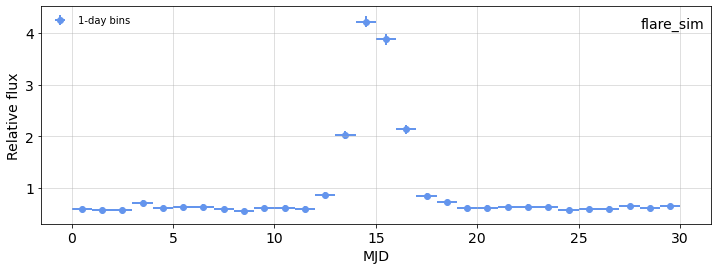

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,ctm,n,w,S,B
0,0.5,1.0,258.299988,1.0,483,"[0.8340875, 0.87314934, 0.74305063, 0.29304907...",368.464569,255.228912
1,1.5,1.0,259.200012,1.0,527,"[0.45398444, 0.083380334, 0.0024971107, 0.0051...",369.748474,256.118225


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,e,ctm,ts,flux,errors,limit
0,0.5,1.0,483,258.299988,1.0,340.2,0.5761,"(-0.047, 0.048)",0.657914
1,1.5,1.0,527,259.200012,1.0,412.8,0.6462,"(-0.049, 0.05)",0.731292


#### About DataFrames
The properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) objects.
For those unfamiliar with pandas, note that one can create "csv" files with the method `to_csv(`*filename*`)`.

The function `query` is very useful: To select the cells with flux>3,

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,e,ctm,ts,flux,errors,limit
14,14.5,1.0,1682,259.200012,1.0,10351.1,4.1235,"(-0.107, 0.108)",4.304522
15,15.5,1.0,1638,259.200012,1.0,10001.9,4.0151,"(-0.105, 0.107)",4.193895


## Views
A `WtLike` object provides a function `view`, which returns a copy but with a different binning. 
So if we want a detailed look at the flare, we can choose an interval. The parameters specify an interval 10 days after the start, and 10 days before the end, with 1/day or 6-hour bins.

CellData.rebin: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>1.25 & n>2


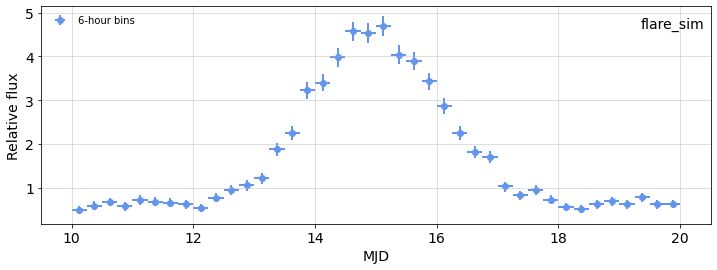

In [ ]:
qday = daily.view(10, -10, 0.25)
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

Bayesian Blocks: partitioning 40 cells using LikelihoodFitness with penalty 5%
	found 9 / 40 blocks.
LightCurve: Loaded 9 / 9 cells for fitting


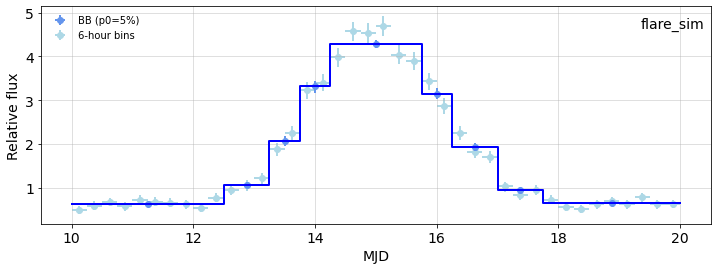

In [ ]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,e,ts,flux,errors,limit
0,11.250,2.50,1334,64.800000,983.4,0.6302,"(-0.031, 0.031)",0.682914
1,12.875,0.75,484,64.800003,814.7,1.0681,"(-0.067, 0.069)",1.185394
2,13.500,0.50,493,64.800003,1674.6,2.0654,"(-0.109, 0.112)",2.255217
3,14.000,0.50,690,64.800003,3620.1,3.3137,"(-0.135, 0.139)",3.547542
4,15.000,1.50,2611,64.799998,16512.7,4.2864,"(-0.089, 0.09)",4.436272
5,16.000,0.50,660,64.800003,3403.5,3.1514,"(-0.132, 0.136)",3.379773
6,16.625,0.75,696,64.800003,2235.2,1.9296,"(-0.086, 0.089)",2.078983
7,17.375,0.75,452,64.800003,648.1,0.9347,"(-0.064, 0.066)",1.045837
8,18.875,2.25,1182,64.800001,914.8,0.6398,"(-0.033, 0.033)",0.695466


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
    debug=False,
    rng=None,
)
Docstring:     
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar | function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : the width of the PSF in (r/rmax)**2 coordinates
- rng : random generator instance, or integer seed
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells
    creates copies with new cells:
      - view
      - phase_view

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -

The three WtLike methods have (preliminary) help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specified, will use '.' if many bin

In [ ]:
WtLike.view?

Signature: WtLike.view(self, *pars, exp_min=None, no_update=False)
Docstring:
Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.

- no_update -- avoid fitting the cells if invoked by LightCurve or WtLike
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from the above code is that one substitues `PointSource` with the designation of a source, for `Simulation`. 

Also, the data files must be available, the config parameter `datapath` set to the relevant folder. 
Currently it is set by a line in `~/.config/wtlike/config.yaml`.  See the [Config help](https://tburnett.github.io/wtlike/config#Config).

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.

All are available in a 2-GB zip file.

The photon and spacecraft data can be checked with `check_data`

The configuration must be valid, with path to data existing

In [ ]:
from wtlike import *
config = Config()
if config.valid:
    #print(check_data())
    source = PointSource('3C 279'); 
    print(source)
    wtl = WtLike(source, exp_min=50)

Source "3C 279" at: (l,b)=(305.104,57.062), nickname P88Y3243
SourceData: week_range: None
SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       185,692 photons from 2008-08-04 to 2021-12-09
	 exposure: 2,940,805 intervals,  average effective area 2771 cm^2 for 87.8 Ms
	 rates:  source 4.06e-07/s, background 3.57e-07/s, TS 182134.1
CellData.rebin: Bin photon data into 696 1-week bins from 54683.0 to 59555.0
LightCurve: select 299 cells for fitting with e>350 & n>2


If the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

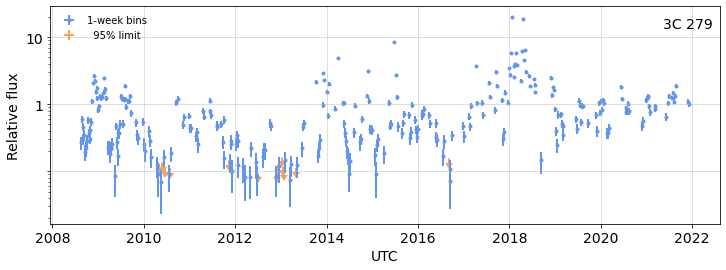

In [ ]:
if config.valid: wtl.plot(log=True, UTC=True);